# Проект: "Выявление профилей потребления"

# Задача:

*Сегментировать покупателей по профилю потребления*
* Проведите исследовательский анализ данных
* Сегментируйте покупателей на основе истории их покупок
* Сформулируйте и проверьте статистические гипотезы


## Материалы:
Ссылка на дашборд(набор №2): https://public.tableau.com/app/profile/janep8663/viz/EP_Final_Project/Sheet1

## Открытие файла  и изучение общей информации

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm.notebook import tqdm
from scipy import stats as st
from scipy.stats import mannwhitneyu, bartlett
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Активируем tqdm для pandas вычислений
tqdm.pandas()

In [3]:
#df = pd.read_csv('')

<b>Добавлю класс, для исследования данных:</b>

In [4]:
class DataFrameCheck:
    """
    Класс для выполнения базовых проверок датасета:
    1) Наличие дубликатов
    2) Проверка пропусков
    3) Общая информация
    4) Вывод статистики
    5) Вывод всей предыдущей информации
    """
    def dup_check(self, dataframe):
        print('Количество дубликатов в записях: {}'.format(dataframe.duplicated().sum()))
        
    def nan_check(self, dataframe):
        print("Пропуски(nan):")
        display(dataframe.isna().sum())
        
    def inf_check(self, dataframe):
        print("Общая информация:")
        display(dataframe.info())
        
    def desc_check(self, dataframe):
        display(dataframe.describe())
    
    def full_info(self, dataframe):
        self.inf_check(dataframe)
        self.dup_check(dataframe)
        self.nan_check(dataframe)
        self.desc_check(dataframe)

## Исследование данных

In [5]:
check = DataFrameCheck()

In [6]:
check.inf_check(df)
check.desc_check(df)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


None

,date,order_id,quantity,price
count,6.737000e+03,6737.000000,6737.000000,6737.000000
mean,2.018855e+09,43128.948345,2.501559,462.028499
std,3.855185e+05,27899.414662,15.266478,871.296064
min,2.018100e+09,12624.000000,1.000000,9.000000
25%,2.019020e+09,14827.000000,1.000000,101.000000
50%,2.019050e+09,68503.000000,1.000000,135.000000
75%,2.019061e+09,70504.000000,1.000000,398.000000
max,2.019103e+09,73164.000000,1000.000000,14917.000000


### Проверка данных на пропуски

In [7]:
check.nan_check(df)

Пропуски(nan):


date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

### Проверка дубликатов

<b>Для начала поищу дубликаты во всём датасете</b>

In [8]:
check.dup_check(df)

Количество дубликатов в записях: 0


<b>Взглянем на те позиции, в которых огромная сумма покупки и много купленных единиц продукции</b>

In [9]:
df[df['quantity'] > 100].sort_values(by='quantity', ascending=False).head(5)

,date,customer_id,order_id,product,quantity,price
5456,2019061815,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0
5071,2019061107,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0
3961,2019052021,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.0
1158,2018121014,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.0
568,2018110108,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.0


In [10]:
df.groupby(['order_id', 'customer_id']).agg({'price':'sum', 
                                'quantity':'sum', 'date':'count'}).reset_index().sort_values(by=['price', 
                                                                                 'quantity', 'date'], ascending=False).head(5)

,order_id,customer_id,price,quantity,date
221,14833,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,113220.0,900,888
1675,70960,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,65220.0,60,60
503,68760,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,43372.0,96,50
942,69531,e382d4c4-a4c9-44d3-97a0-a8868e122563,28973.0,7,7
1772,71148,ae6940d3-a1c7-4997-8853-a5b8afc60d51,28784.0,18,16


In [11]:
df[df['order_id'] == 71743]

,date,customer_id,order_id,product,quantity,price
5456,2019061815,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0


In [12]:
df[df['order_id'] == 14833].groupby(['product']).agg({'price':'sum', 'quantity':'sum'})

,price,quantity
product,,
"Рассада Кабачка сорт Аэронавт, кассета по 6шт",8880.0,75
Рассада Кабачка сорт Белогор кассета 6 шт E6,8880.0,75
"Рассада Кабачка сорт Горный, кассета по 6шт",8880.0,75
Рассада Кабачка сорт Зебра кассета 6 шт E6,8880.0,75
Рассада Кабачка сорт Золотинка кассета 6 шт E6,8880.0,75
"Рассада Кабачка сорт Сосновский, кассета по 6шт",8880.0,75
Рассада Огурец Кристина ячейки по 6 шт Е6,8880.0,75
Рассада Огурец Фараон ячейки по 6 шт Е6,8880.0,75
Рассада Огурца сорт Каролина кассета 6 шт E6,8880.0,75


### Вывод по исследованию данных:

* Столбец с датой содержит год-месяц-день и часть от времени, в виде часа
    * Дату надо поменять с int на datetime
    * У нас имеются данные за период - год и один месяц
* Столбец id заказа, quantity, price - поменять на более облегчённую версию типа данных
* Столбец product надо лемматизировать
* В данных (quantity, price) есть выбросы, которые надо исследовать и по возможности убрать
* В датафрейме обнаружены дубликаты, которые надо убрать, иначе статистика будет искажена

### Очистка и преобразование данных

<b>Посчитаем итоговую сумму, умножив цену за единицу товара на количество купленных единиц продукции</b>

In [13]:
new_df = df.query('quantity < 1000 and order_id != 14833')
new_df['total'] = new_df['price'] * new_df['quantity']

In [14]:
new_df['date'] = pd.to_datetime(new_df['date'], format='%Y%m%d%H', errors='ignore')

In [15]:
new_df['day'] = new_df['date'].dt.dayofyear
new_df['month'] = new_df['date'].dt.month
new_df['year'] = new_df['date'].dt.year

In [16]:
new_df['order_id'] = new_df['order_id'].astype('uint32')
new_df['price'] = new_df['price'].astype('uint16')
new_df['quantity'] = new_df['quantity'].astype('uint16')

<b>Проверим изменения</b>

In [17]:
check.inf_check(new_df)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5848 entries, 0 to 6736
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5848 non-null   datetime64[ns]
 1   customer_id  5848 non-null   object        
 2   order_id     5848 non-null   uint32        
 3   product      5848 non-null   object        
 4   quantity     5848 non-null   uint16        
 5   price        5848 non-null   uint16        
 6   total        5848 non-null   float64       
 7   day          5848 non-null   int64         
 8   month        5848 non-null   int64         
 9   year         5848 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2), uint16(2), uint32(1)
memory usage: 411.2+ KB


None

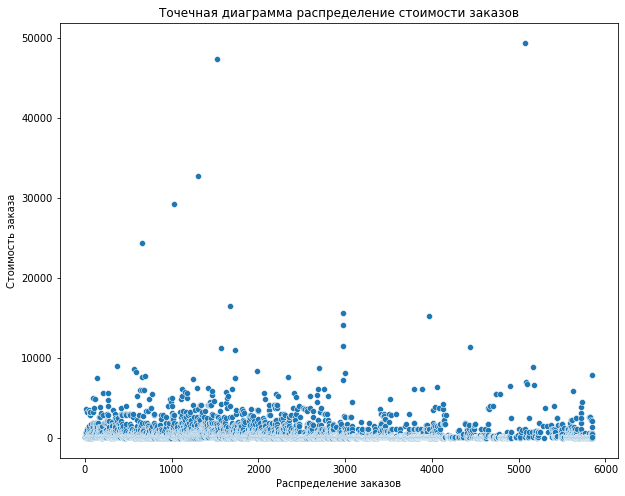

In [18]:
x_val = pd.Series(range(0, len(new_df)))
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x_val, y=new_df['total'])
plt.title('Точечная диаграмма распределение стоимости заказов')
plt.ylabel('Стоимость заказа')
plt.xlabel('Распределение заказов')
plt.show()

In [19]:
display(new_df['date'].min())
display(new_df['date'].max())

Timestamp('2018-10-01 00:00:00')

Timestamp('2019-10-31 16:00:00')

## Анализ данных

### Построение гистограмм распределения

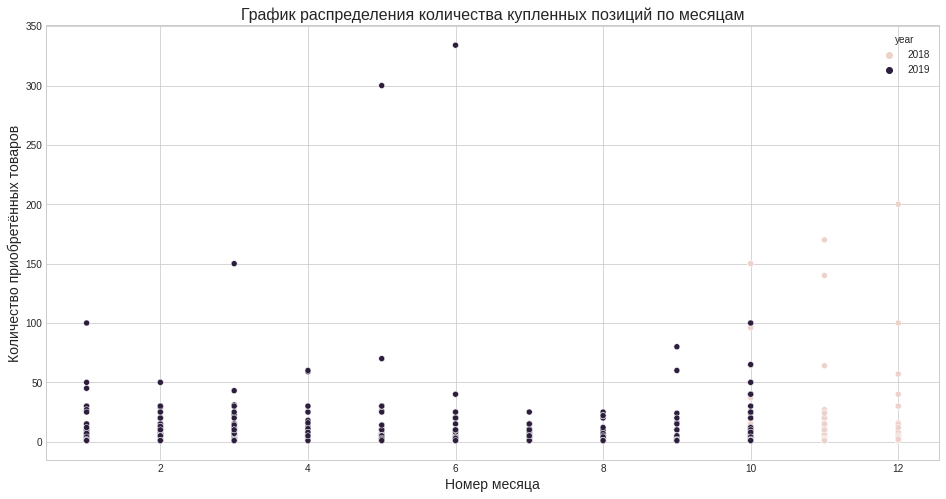

In [20]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(16, 8))
    sns.scatterplot(x=new_df['month'], y=new_df['quantity'], hue=new_df['year'])
    plt.title("График распределения количества купленных позиций по месяцам", fontsize=16)
    plt.xlabel("Номер месяца", fontsize=14)
    plt.ylabel("Количество приобретённых товаров", fontsize=14)
    plt.show()

<b>Теперь по дням</b>

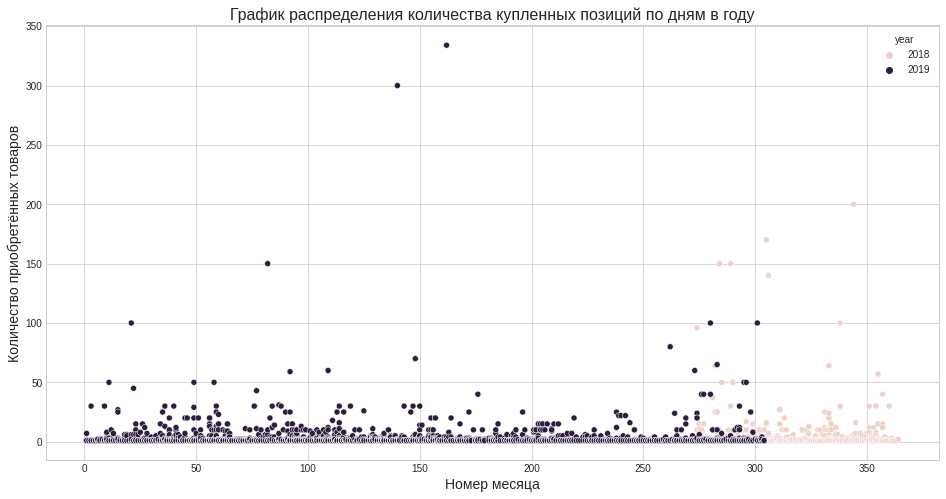

In [21]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(16, 8))
    sns.scatterplot(x=new_df['day'], y=new_df['quantity'], hue=new_df['year'])
    plt.title("График распределения количества купленных позиций по дням в году", fontsize=16)
    plt.xlabel("Номер месяца", fontsize=14)
    plt.ylabel("Количество приобретённых товаров", fontsize=14)
    plt.show()

<b>Покупки и их суммарное количество по месяцам распределено равномерно, между сентябрём и октябрём наблюдается тенденция роста количества покупок</b>

<b>Взглянем на сумму заказов по дням в году</b>

In [22]:
sum_per_day = new_df.groupby(['year', 'day']).agg({'total':'sum'}).reset_index()
sum_per_month = new_df.groupby(['year', 'month']).agg({'total':'sum'}).reset_index()

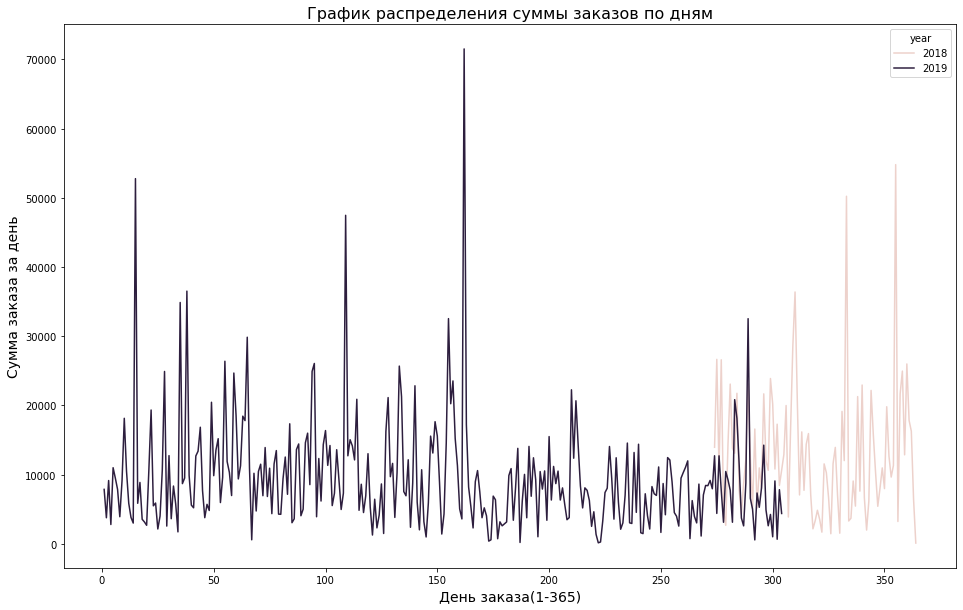

In [23]:
plt.figure(figsize=(16, 10))
sns.lineplot(x=sum_per_day['day'], y=sum_per_day['total'], hue=sum_per_day['year'])
plt.title("График распределения суммы заказов по дням", fontsize=16)
plt.xlabel("День заказа(1-365)", fontsize=14)
plt.ylabel("Сумма заказа за день", fontsize=14)
plt.show()

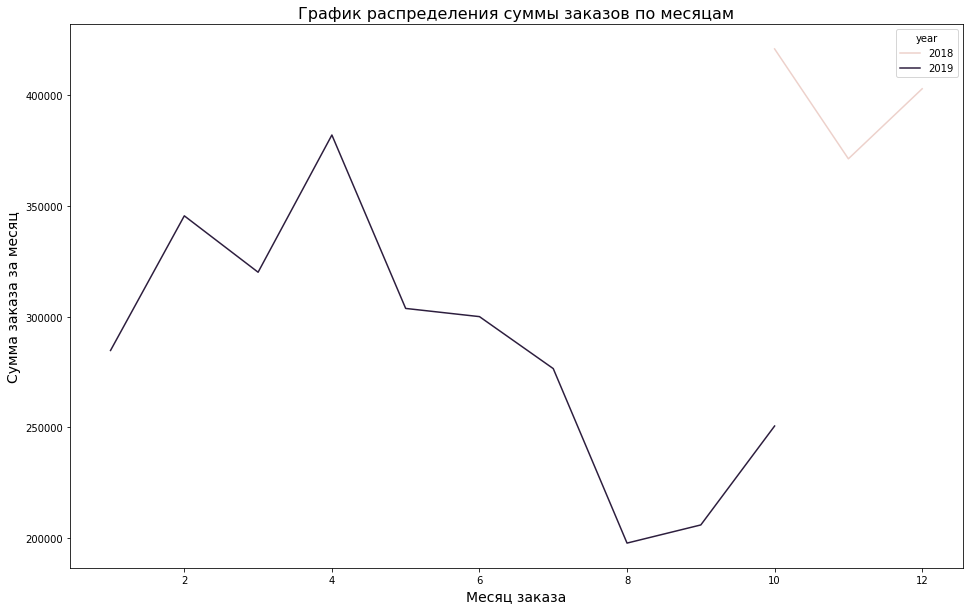

In [24]:
plt.figure(figsize=(16, 10))
sns.lineplot(x=sum_per_month['month'], y=sum_per_month['total'], hue=sum_per_month['year'])
plt.title("График распределения суммы заказов по месяцам", fontsize=16)
plt.xlabel("Месяц заказа", fontsize=14)
plt.ylabel("Сумма заказа за месяц", fontsize=14)
plt.show()

<b>Вывод: Суммарная стоимость заказов по дням распределена хаотично, сезонности не наблюдается</b>
* Информации за 2018 год совсем немного данных, но разброс тот же
* Имеются большие суммы заказов в начале года, середине и ближе к осени

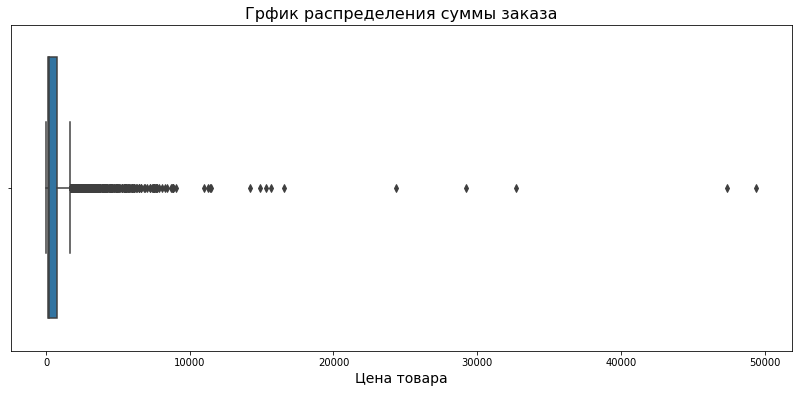

In [25]:
plt.figure(figsize=(14, 6))
sns.boxplot(x=new_df['total'])
plt.title('Грфик распределения суммы заказа', fontsize=16)
plt.xlabel('Цена товара', fontsize=14)
plt.show()

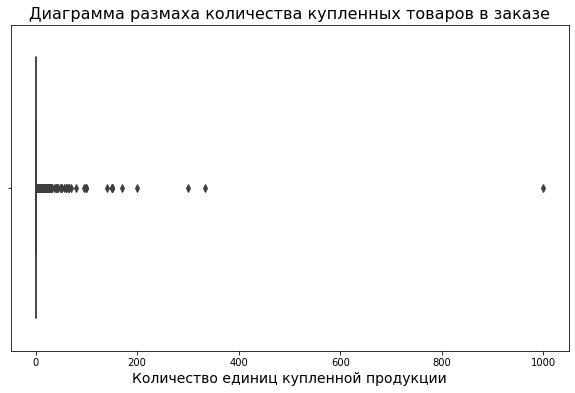

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['quantity'])
plt.title('Диаграмма размаха количества купленных товаров в заказе', fontsize=16)
plt.xlabel('Количество единиц купленной продукции', fontsize=14)
plt.show()

### Категоризация  клиентов

In [27]:
def clear_text(text):
    """Функция очистки текста от лишних знаков и цифр
        Дополнительно применена проверка, что если второго слова нет или оно меньше 3 символов
        (возмоэные артефакты), то вывести только одно слово, иначе 2
    """
    text = re.sub(r'[^а-яА-ЯёЁ ]', ' ', text).lower().split()
    if len(text) == 1 or len(text[1]) < 3:
        return text[0]
    else:
        return " ".join(text[0:2])

<b>Очистим столбец product и добавим каждый элемент отдельного списка в общий список, 
для дальнейшего подсчёта:</b>

In [28]:
new_df['clear_frases'] = new_df['product'].progress_apply(lambda x: clear_text(x))

  0%|          | 0/5848 [00:00<?, ?it/s]

<b>Немного толоки и готово:</b>

Решил не делать только для первого слова, в противном случае есть шанс попадания товара в случайную категорию

In [29]:
categorized_list = [('дыня млада', 'растения'), ('муляж лимон', 'декор'), ('вешалка с', 'хранение'), ('нефролепис бостон', 'растения'),
 ('солидаго желтый', 'растения'), ('суккулент микс', 'растения'), ('роза чайно', 'растения'), ('однолетнее растение', 'растения'),
 ('антижир мл', 'бытовая химия'), ('ёрш для', 'кухня'), ('петуния фиолетово', 'растения'), ('маттиола ночная', 'растения'),
 ('патиссон зонтик', 'растения'), ('мантоварка пароварка', 'кухня'), ('бузульник пржевальского', 'растения'),
 ('ведро полимербыт', 'хозтовары'), ('космея снежный', 'растения'), ('агератум рассада', 'растения'),
 ('скалка силиконовая', 'кухня'), ('насадка на', 'ремонт'), ('лапчатка огненное', 'растения'), ('муляж яблоко', 'декор'),
 ('эхеверия перл', 'растения'), ('гиацинт голубой', 'растения'), ('гардения см', 'растения'), ('ковер придверный', 'декор'),
 ('цинния хаага', 'растения'), ('пододеяльник х', 'текстиль для дома'), ('душица обыкновенная', 'растения'),
 ('венчик с', 'кухня'), ('мускари в', 'растения'), ('календула бронзовая', 'растения'), ('космея кэнди', 'растения'),
 ('арбуз холодок', 'растения'), ('рассада томата', 'растения'), ('полотенце прессованное', 'текстиль для дома'),
 ('муляж желудь', 'декор'), ('доска разделочная', 'кухня'), ('примула желтая', 'растения'), ('термометр уличный', 'товары для дома'),
 ('отжим для', 'хозтовары'), ('муляж гранат', 'декор'), ('вербейник монетчатый', 'растения'), ('электроштопор белый', 'кухня'),
 ('чехол металлизированый', 'хозтовары'), ('картофелемялка металлическая', 'кухня'), ('примула акаулис', 'растения'),
 ('пуансеттия в', 'растения'), ('коврик придверный', 'текстиль для дома'), ('скатерть круглая', 'кухня'),
 ('отделитель косточек', 'кухня'), ('скатерть рим', 'кухня'), ('ящик почтовый', 'товары для дома'), ('нож универсальный', 'кухня'),
 ('шпагат полипропиленовый', 'хозтовары'), ('карниз алюминиевый', 'мебель'), ('коврик м', 'текстиль для дома'),
 ('мерный стакан', 'кухня'), ('крепеж для', 'мебель'), ('термокружка синий', 'туризм'), ('лоток для', 'кухня'),
 ('дендробиум яблоневый', 'растения'), ('подголовник х', 'ванная'), ('стремянка ступени', 'инструменты'), ('сумка тележка', 'хозтовары'),
 ('швабра для', 'хозтовары'), ('вербена крупноцветковая', 'растения'), ('рассада кабачка', 'растения'), ('ложка обувная', 'хозтовары'),
 ('рассада пряной', 'растения'), ('набор вешалок', 'хранение'), ('мыло ручной', 'ванная'), ('капуста декоративная', 'декор'),
 ('энотера миссурийская', 'растения'), ('нолина в', 'растения'), ('муляж персик', 'декор'), ('коврик в', 'текстиль для дома'),
 ('огурец закусочный', 'растения'), ('пылесос красный', 'бытовая техника'), ('одеяло микрофибра', 'текстиль для дома'),
 ('кружка марли', 'кухня'), ('эвкалипт сильвердроп', 'растения'), ('калибрахоа желто', 'растения'), ('томат балконное', 'растения'),
 ('лобелия рассада', 'растения'), ('бакопа ампельная', 'растения'), ('рассада огурец', 'растения'), ('фикус каучуконосный', 'растения'),
 ('стремянки ступени', 'ремонт'), ('салатник биантэ', 'кухня'), ('подушка декоративная', 'декор'), ('сантолина см', 'растения'),
 ('набор столовых', 'кухня'), ('вакуумный пакет', 'хозтовары'), ('бегония ампельная', 'растения'), ('кастрюля чугунная', 'кухня'),
 ('муляж хлеб', 'декор'), ('миска для', 'кухня'), ('концентрат для', 'бытовая химия'), ('коробка прямоугольная', 'хранение'),
 ('змееголовник молдавский', 'растения'), ('пружина дверная', 'мебель'), ('петуния ампельная', 'растения'), ('физостегия вергинская', 'растения'),
 ('простыня на', 'текстиль для дома'), ('корыто оцинкованное', 'ремонт'), ('подвесное кашпо', 'декор'), ('вешалка перекладина', 'хранение'),
 ('муляж персики', 'декор'), ('петуния красные', 'растения'), ('полки торонто', 'мебель'), ('банка из', 'кухня'),
 ('обувница квадро', 'мебель'), ('пеларгония душистая', 'растения'), ('полки рио', 'мебель'), ('драцена фрагранс', 'растения'),
 ('мыльница пластмассовая', 'ванная'), ('цикламен комнатный', 'растения'), ('монарда гибридная', 'растения'),
 ('коврик резиновый', 'текстиль для дома'), ('полки пекин', 'мебель'), ('искусственный лист', 'ремонт'), ('петуния оранжевая', 'растения'),
 ('щётка для', 'хозтовары'), ('дыня медовый', 'растения'), ('коврик противоскользящий', 'ванная'), ('бальзамин валера', 'растения'),
 ('розмарин в', 'растения'), ('салатник романтик', 'кухня'), ('пена для', 'ванная'), ('хризантема белая', 'растения'),
 ('пеларгония зональная', 'растения'), ('миска фазенда', 'кухня'), ('покрывало вельсофт', 'текстиль для дома'),
 ('миска пластмассовая', 'туризм'), ('муляж оранжевое', 'декор'), ('сковорода эксперт', 'кухня'), ('щетка палубная', 'хозтовары'),
 ('огурец засолочный', 'растения'), ('лантана см', 'растения'), ('веревка полипропиленовая', 'хозтовары'),
 ('декоративная композиция', 'декор'), ('роза мини', 'растения'), ('хлебница деревянная', 'кухня'), ('лавр в', 'растения'),
 ('ёрш радиаторный', 'хозтовары'), ('спатифиллум свит', 'растения'), ('алиссум скальный', 'растения'), ('набор эмалированных', 'кухня'),
 ('базилик пурпурные', 'растения'), ('урна уличная', 'хранение'), ('петуния каскад', 'растения'), ('антинакипин для', 'бытовая химия'),
 ('сушилка', 'хозтовары'), ('пылесос синий', 'бытовая техника'), ('ведро пластиковое', 'хозтовары'), ('соковарка ве', 'кухня'),
 ('насадка отжим', 'хозтовары'), ('термокружка яромир', 'туризм'), ('жестяная банка', 'еда'), ('наматрацник бархатный', 'текстиль для дома'),
 ('астра рассада', 'растения'), ('рудбекия тайгер', 'растения'), ('рассада пеларгония', 'растения'), ('томат государь', 'растения'),
 ('клен ложноплатановый', 'растения'), ('муляж чеснок', 'декор'), ('рассада тыквы', 'растения'), ('целозия гребенчатая', 'растения'),
 ('решетка вентиляционная', 'ремонт'), ('губка спираль', 'хозтовары'), ('термос л', 'туризм'), ('калатея кроката', 'растения'),
 ('флокс метельчатый', 'растения'), ('рассада огурца', 'растения'), ('буддлея вейера', 'растения'), ('кастрюля алюминиевая', 'кухня'),
 ('годеция рембранд', 'растения'), ('гипсофила аврора', 'растения'), ('петуния бургунди', 'растения'), ('петрушка корневая', 'растения'),
 ('роза кустовая', 'растения'), ('ёрш унитазный', 'хозтовары'), ('полки лондон', 'мебель'), ('дыня золотой', 'растения'),
 ('антуриум андрианум', 'растения'), ('ёрш бутылочный', 'хозтовары'), ('кружка мерная', 'кухня'), ('измерительный угольник', 'ремонт'),
 ('калибрахоа малиновая', 'растения'), ('хлебница пластмасовая', 'кухня'), ('петуния махровая', 'растения'),
 ('халат вафельный', 'текстиль для дома'), ('скребок кондитерский', 'кухня'), ('колокольчик персиколистный', 'растения'),
 ('фатсия японская', 'растения'), ('набор для', 'товары для дома'), ('цинния оранжевый', 'растения'), ('лоток л', 'хранение'),
 ('нож поварской', 'кухня'), ('лестница стремянка', 'ремонт'), ('чайная ложка', 'кухня'), ('ранункулус клуни', 'растения'),
 ('фуксия прямостоячая', 'растения'), ('чайник заварочный', 'кухня'), ('диффенбахия см', 'растения'), ('настурция драгоценность', 'растения'),
 ('ткань универсальная', 'текстиль для дома'), ('доска гладильная', 'хозтовары'), ('набор сверел', 'инструменты'),
 ('кружка мл', 'кухня'), ('бархатцы веселая', 'растения'), ('рассада дыни', 'растения'), ('хамедорея см', 'растения'),
 ('коробка для', 'хранение'), ('линейка длина', 'канцтовары'), ('ополаскиватель для', 'ванная'), ('петуния желтая', 'растения'),
 ('вербена ярко', 'растения'), ('фоторамка на', 'декор'), ('петля стрела', 'ремонт'), ('мелисса лекарственная', 'растения'),
 ('флокс друммонда', 'растения'), ('насадка', 'хозтовары'), ('бельевые прищепки', 'хозтовары'), ('петуния черная', 'растения'),
 ('салатник аспен', 'кухня'), ('весы настольные', 'хозтовары'), ('кольца для', 'декор'), ('салфетка махровая', 'текстиль для дома'),
 ('защитный экран', 'кухня'), ('горох амброзия', 'растения'), ('тортница', 'кухня'), ('камнеломка арендса', 'растения'),
 ('диффенбахия камилла', 'растения'), ('космея клюквенный', 'растения'), ('насадка для', 'хозтовары'), ('настурция лунный', 'растения'),
 ('этажерка цветочная', 'декор'), ('эпипремнум ауреум', 'растения'), ('стремянка алюминиевая', 'ремонт'),
 ('дыня алтайская', 'растения'), ('пуансеттия см', 'растения'), ('баклажан самурай', 'растения'), ('кружка для', 'кухня'),
 ('ясколка войлочная', 'растения'), ('чайник эмалированный', 'кухня'), ('просеиватель для', 'кухня'), ('скатерть джулия', 'текстиль для дома'),
 ('мантоварка алюминиевая', 'кухня'), ('мирт см', 'растения'), ('термос со', 'туризм'), ('соковарка алюминиевая', 'кухня'),
 ('эвкалипт гунни', 'растения'), ('муляж клубника', 'декор'), ('веник для', 'хозтовары'), ('томата помидор', 'растения'),
 ('перчатки специальная', 'хозтовары'), ('эхеверия микс', 'растения'), ('хризантема кустовая', 'растения'), ('фиалка см', 'растения'),
 ('шалфей овощной', 'растения'), ('петуния рассада', 'растения'), ('комод эльфпласт', 'мебель'), ('стяжка оконная', 'ремонт'),
 ('левкой рассада', 'растения'), ('фуксия белая', 'растения'), ('алоэ вера', 'растения'), ('полотенце кухонное', 'кухня'),
 ('щетка хозяйственная', 'хозтовары'), ('фаленопсис королевский', 'растения'), ('ручка мебельная', 'мебель'),
 ('вилка столовая', 'кухня'), ('стремянка ступеней', 'ремонт'), ('каллуна гарден', 'растения'), ('противень прямоугольный', 'кухня'),
 ('гвоздика садовая', 'растения'), ('таз алюминиевый', 'хозтовары'), ('шприц кондитерский', 'кухня'), ('вербена красная', 'растения'),
 ('складная картонная', 'хранение'), ('хризантема корейская', 'растения'), ('скатерть х', 'текстиль для дома'),
 ('набор форм', 'кухня'), ('лобелия регатта', 'растения'), ('фаленопсис люкс', 'растения'), ('муляж баклажан', 'декор'),
 ('папоротник страусник', 'растения'), ('кружка о', 'кухня'), ('совок и', 'хозтовары'), ('искусственная композиция', 'декор'),
 ('капуста цветная', 'растения'), ('корзинка с', 'хранение'), ('лаванда в', 'растения'), ('антуриум тропик', 'растения'),
 ('стремянка металлическая', 'ремонт'), ('цикламен розовый', 'растения'), ('стремянка х', 'ремонт'), ('укроп обильнолистный', 'растения'),
 ('бидон пластмассовый', 'хранение'), ('арбуз огонек', 'растения'), ('мыло жидкое', 'ванная'), ('лопатка прорезями', 'хозтовары'),
 ('скатерть беатрис', 'текстиль для дома'), ('незабудка смесь', 'растения'), ('базилик смесь', 'растения'),
 ('мыло скраб', 'ванная'), ('отбеливатель пероксоль', 'бытовая химия'), ('кореопсис толл', 'растения'),
 ('салфетка на', 'декор'), ('фуксия ампельная', 'растения'), ('стиральный биопорошок', 'бытовая химия'),
 ('подголовник для', 'ванная'), ('орехоколка', 'кухня'), ('калибрахоа желтая', 'растения'), ('муляж манго', 'декор'),
 ('толкушка для', 'кухня'), ('сметка с', 'хозтовары'), ('аргирантерум рассада', 'растения'), ('гайлардия крупноцветковая', 'растения'),
 ('кувшин виктория', 'кухня'), ('хризолидокарпус лутесценс', 'растения'), ('рукав для', 'текстиль для дома'),
 ('рассада зелени', 'растения'), ('эшшольция карминный', 'растения'), ('завертка форточная', 'ремонт'),
 ('термокружка вакуумная', 'туризм'), ('мини сковорода', 'кухня'), ('аспарагус см', 'растения'), ('капуста брюссельская', 'растения'),
 ('тимьян крымский', 'растения'), ('скатерть виниловая', 'текстиль для дома'), ('муляж апельсин', 'декор'),
 ('калибрахоа фиолетовая', 'растения'), ('толкушка деревянная', 'кухня'), ('полки токио', 'мебель'), ('чистящий крем', 'бытовая химия'),
 ('ведро резинопластиковое', 'хозтовары'), ('вербена ампельная', 'растения'), ('цикламен см', 'растения'),
 ('стеллаж для', 'мебель'), ('щетка универсальная', 'хозтовары'), ('патиссон нло', 'растения'), ('хлебница', 'кухня'),
 ('средство против', 'бытовая химия'), ('тыква крупноплодная', 'растения'), ('чехол хлопок', 'текстиль для дома'),
 ('кружка шэйдс', 'кухня'), ('молодило в', 'растения'), ('синнингия глоксиния', 'растения'), ('фен дорожный', 'бытовая техника'),
 ('салатник воларэ', 'кухня'), ('патиссон диск', 'растения'), ('иссоп лекарственный', 'растения'), ('блюдо серия', 'кухня'),
 ('вешалка стойка', 'мебель'), ('фиалка махровая', 'растения'), ('жидкое мыло', 'ванная'), ('рассада арбуза', 'растения'),
 ('чабер см', 'растения'), ('кружка бамбук', 'кухня'), ('вкладыши для', 'хранение'), ('муляж морковь', 'декор'),
 ('этажерка для', 'мебель'), ('сумка для', 'хозтовары'), ('перчатки для', 'хозтовары'), ('банка стеклянная', 'хранение'),
 ('скатерть прямоугольная', 'текстиль для дома'), ('каланхое каландива', 'растения'), ('махровое полотенце', 'текстиль для дома'),
 ('цинния ацтек', 'растения'), ('цинния коралловая', 'растения'), ('пеларгония розебудная', 'растения'),
 ('одеяло белое', 'текстиль для дома'), ('кофр для', 'хранение'), ('термокружка красный', 'туризм'),
 ('примула рассада', 'растения'), ('фал капроновый', 'хозтовары'), ('джункус пенсил', 'растения'), ('короб стеллажный', 'хранение'),
 ('шеффлера лузеана', 'растения'), ('цветок искусственный', 'декор'), ('вешалка деревянная', 'хранение'),
 ('холодная сварка', 'ремонт'), ('базилик зеленый', 'растения'), ('молодило микс', 'растения'), ('столовый нож', 'кухня'),
 ('гвоздика турецкая', 'растения'), ('цинерания рассада', 'растения'), ('кондиционер для', 'бытовая химия'),
 ('гортензия метельчатая', 'растения'), ('лук порей', 'растения'), ('муляж красное', 'декор'), ('пеларгония плющелистная', 'растения'),
 ('кориандр стимул', 'растения'), ('крассула см', 'растения'), ('вешалка надверная', 'хранение'), ('ароматизированное средство', 'бытовая химия'),
 ('покрывало жаккард', 'текстиль для дома'), ('вешалка для', 'хранение'), ('салатник кутюр', 'кухня'),
 ('скатерть муза', 'текстиль для дома'), ('набор махровых', 'текстиль для дома'), ('аквилегия обыкновенная', 'растения'),
 ('кружка лили', 'кухня'), ('колокольчик карпатский', 'растения'), ('ножеточка универсальная', 'кухня'),
 ('набор ковров', 'текстиль для дома'), ('сушилка уличная', 'хозтовары'), ('сервировочная салфетка', 'декор'),
 ('плечики пластмассовые', 'хранение'), ('набор стаканов', 'кухня'), ('искусственная лиана', 'декор'),
 ('муляж булка', 'декор'), ('зубная паста', 'ванная'), ('бальзамин новогвинейский', 'растения'),
 ('новогоднее дерево', 'растения'), ('универсальный нож', 'кухня'), ('мята махито', 'растения'),
 ('сверло фреза', 'ремонт'), ('сверло по', 'ремонт'), ('портулак рассада', 'растения'), ('лен небесная', 'растения'),
 ('хлорофитум см', 'растения'), ('бульонница мистигри', 'растения'), ('клубника мара', 'растения'), ('дозатор для', 'ванная'),
 ('сменный блок', 'хозтовары'), ('эхеверия лила', 'растения'), ('корзина для', 'хранение'), ('крассула овата', 'растения'),
 ('подарочный набор', 'растения'), ('простыня сатиновая', 'текстиль для дома'), ('набор кухонных', 'кухня'),
 ('бегония клубневая', 'растения'), ('скатерть ажурная', 'текстиль для дома'), ('нивянник ромашка', 'растения'),
 ('автоматическая щетка', 'бытовая техника'), ('астра альпийская', 'растения'), ('петля приварная', 'мебель'),
 ('тимьян овощной', 'растения'), ('набор прищепок', 'хозтовары'), ('салатник арти', 'кухня'), ('вешалка настенная', 'хранение'),
 ('настенная сушилка', 'хозтовары'), ('циперус зумула', 'растения'), ('муляж райские', 'декор'), ('пресс для', 'кухня'),
 ('виола рассада', 'растения'), ('дендробиум фиолетовый', 'растения'), ('калибрахоа сиреневая', 'растения'),
 ('полка для', 'мебель'), ('петля рояльная', 'мебель'), ('петуния синяя', 'растения'), ('двуспальное постельное', 'текстиль для дома'),
 ('вербена микс', 'растения'), ('вербена рассада', 'растения'), ('ложка кухонная', 'кухня'), ('урна пепельница', 'хранение'),
 ('муляж зеленое', 'декор'), ('салфетка камушки', 'декор'), ('алиссум лобулярия', 'растения'), ('совок металический', 'хозтовары'),
 ('сциндапсус в', 'растения'), ('цветущее комнатное', 'растения'), ('вантуз с', 'хозтовары'), ('ерш для', 'хозтовары'),
 ('вешалка металлическая', 'хранение'), ('мешок для', 'хранение'), ('Термокружка мл', 'туризм'), ('колеус рассада', 'растения'),
 ('подкладка под', 'текстиль для дома'), ('цитрофортунелла кумкват', 'растения'), ('пеларгония тюльпановидная', 'растения'),
 ('лилейник высокорослый', 'растения'), ('муляж томат', 'декор'), ('эхинацея микс', 'растения'), ('сиденье в', 'мебель'),
 ('швабра сальса', 'хозтовары'), ('пробка для', 'хозтовары'), ('весы электронные', 'бытовая техника'), ('коврик ворсовый', 'текстиль для дома'),
 ('кружка нордик', 'кухня'), ('ящик для', 'хранение'), ('лаватера монт', 'растения'), ('кастрюля круглая', 'кухня'),
 ('космея лимонад', 'растения'), ('мята перечная', 'растения'), ('подрукавник для', 'хозтовары'), ('корзина на', 'хранение'),
 ('калоцефалус брауни', 'растения'), ('измерительный алюминиевый', 'ремонт'), ('тряпка для', 'текстиль для дома'),
 ('набор кружек', 'кухня'), ('импатиенс нью', 'растения'), ('ковш пластмассовый', 'хранение'), ('фарфоровая кружка', 'кухня'),
 ('полки нью', 'мебель'), ('спатифиллум шопен', 'растения'), ('салатник эмпилабль', 'кухня'), ('гимнокалициум микс', 'растения'),
 ('тимьян в', 'растения'), ('одеяло пуховое', 'текстиль для дома'), ('пеларгония см', 'растения'), ('муляж вишня', 'декор'),
 ('комплект постельного', 'текстиль для дома'), ('сумка хозяйственная', 'хранение'), ('основание для', 'ремонт'),
 ('петуния розовая', 'растения'), ('камнеломка тенистая', 'растения'), ('азалия индика', 'растения'), ('вешалка слуга', 'хранение'),
 ('перчатки из', 'хозтовары'), ('кухонные ножницы', 'кухня'), ('барвинок синий', 'растения'), ('швабра многофункциональная', 'хозтовары'),
 ('готовая скатерть', 'текстиль для дома'), ('анемона белый', 'растения'), ('петуния сиреневая', 'растения'),
 ('гортензия микс', 'растения'), ('муляж груша', 'декор'), ('радермахера см', 'растения'), ('рассада остеоспермум', 'растения'),
 ('петуния крупноцветковая', 'растения'), ('томат детерминантный', 'растения'), ('шнур резиновый', 'хозтовары'),
 ('вешалка ника', 'хранение'), ('чайник электрический', 'кухня'), ('вероника колосковая', 'растения'), ('универсальное средство', 'бытовая химия'),
 ('наволочка арктик', 'текстиль для дома'), ('термостакан ве', 'туризм'), ('сальвия рассада', 'растения'),
 ('осина обыкновенная', 'растения'), ('емкость для', 'хранение'), ('терка для', 'кухня'), ('котел алюминиевый', 'кухня'),
 ('петуния красно', 'растения'), ('салфетка', 'декор'), ('комплект махровых', 'текстиль для дома'), ('фуксия синяя', 'растения'),
 ('декоративная коробка', 'декор'), ('хризантема сиреневая', 'растения'), ('ведро овальное', 'хозтовары'),
 ('крючок проволочный', 'хранение'), ('замиокулькас см', 'растения'), ('пьезозажигалка с', 'кухня'), ('скатерть жаклин', 'текстиль для дома'),
 ('полки мадрид', 'мебель'), ('дендробиум санок', 'растения'), ('флокс растопыренный', 'растения'), ('хризантема красная', 'растения'),
 ('салфетница металлическая', 'кухня'), ('кухонное полотенце', 'текстиль для дома'), ('хоста микс', 'растения'),
 ('адиантум лиза', 'растения'), ('миксер серо', 'кухня'), ('перчатки резиновые', 'хозтовары'), ('тагетис крупноцветковый', 'растения'),
 ('совок для', 'хозтовары'), ('шнур хозяйственный', 'хозтовары'), ('соковыжималка для', 'кухня'), ('кофр малый', 'хранение'),
 ('клубника альба', 'растения'), ('ванна л', 'хозтовары'), ('тележка хозяйственная', 'хозтовары'), ('вешалка сушилка', 'хозтовары'),
 ('огурец багратион', 'растения'), ('рассада капусты', 'растения'), ('бегония вечноцветущая', 'растения'), ('фуксия малиновая', 'растения'),
 ('арбуз сибирские', 'растения'), ('рыбочистка с', 'кухня'), ('коробка перфорированная', 'хранение'),
 ('калибрахоа ампельная', 'растения'), ('бак для', 'хранение'), ('гербера комнатная', 'растения'),
 ('щетка утюжок', 'хозтовары'), ('любисток удалец', 'растения'), ('муррайя см', 'растения'),
 ('банка со', 'хранение'), ('вешалка напольная', 'хранение'), ('петуния гибридная', 'растения'),
 ('кодонанта укорененный', 'растения'), ('салатник рапсоди', 'кухня'), ('кисточка силиконовая', 'кухня'),
 ('овощечистка с', 'кухня'), ('вантуз черный', 'хозтовары'), ('амариллис темно', 'растения'), ('циния рассада', 'растения'),
 ('скатерть азалия', 'текстиль для дома'), ('комплект для', 'хозтовары'), ('набор инструментов', 'инструменты'),
 ('стакан пластмассовый', 'кухня'), ('базилик овощной', 'растения'), ('морковь детская', 'растения'), ('герань домашняя', 'растения'),
 ('штора текстильная', 'текстиль для дома'), ('розмарин см', 'растения'), ('ткань для', 'текстиль для дома'),
 ('тюльпан лувр', 'растения'), ('нетканые салфетки', 'хозтовары'), ('примула комнатная', 'растения'), ('пахира акватика', 'растения'),
 ('паста зубная', 'ванная'), ('кориандр в', 'растения'), ('земляника садовая', 'растения'), ('дыня колхозница', 'растения'),
 ('муляж лайм', 'декор'), ('капсикум сальса', 'растения'), ('шило с', 'инструменты'), ('штора со', 'текстиль для дома'),
 ('перчатки латексные', 'хозтовары'), ('гвоздика травянка', 'растения'), ('скатерть лувр', 'текстиль для дома'),
 ('гипоаллергенный концентрированный', 'бытовая химия'), ('коврик хлопковый', 'текстиль для дома'), ('фатсия см', 'растения'),
 ('роза одноголовая', 'растения'), ('кореопсис золотой', 'растения'), ('газания рассада', 'растения'), ('скребок для', 'хозтовары'),
 ('петуния простая', 'растения'), ('скиммия японская', 'растения'), ('простынь вафельная', 'текстиль для дома'),
 ('весы напольные', 'бытовая техника'), ('муляж тыквы', 'декор'), ('фиксатор шар', 'мебель'), ('петуния белая', 'растения'),
 ('тарелка десертная', 'кухня'), ('гиностемма укорененный', 'растения'), ('декабрист в', 'растения'), ('набор ножей', 'кухня'),
 ('термокружка забава', 'туризм'), ('сковорода см', 'кухня'), ('корзина пластиковая', 'хранение'), ('вигна лилиана', 'растения'),
 ('набор фужеров', 'кухня'), ('скатерть сидней', 'текстиль для дома'), ('капуста брокколи', 'растения'),
 ('афеляндра скуарроса', 'растения'), ('вешалка плечики', 'хранение'), ('шеффлера голд', 'растения'), ('капуста белокочанная', 'растения'),
 ('фуксия в', 'растения'), ('лантана в', 'растения'), ('гвоздика стандартная', 'растения'), ('скатерть династия', 'текстиль для дома'),
 ('столовая ложка', 'кухня'), ('петуния небесно', 'растения'), ('табак курительный', 'растения'), ('фаленопсис желтый', 'растения'),
 ('юкка нитчатая', 'растения'), ('форма а', 'кухня'), ('утюг черный', 'бытовая техника'), ('набор бокалов', 'кухня'),
 ('табак бордовый', 'растения'), ('тимьян см', 'растения'), ('калибрахоа розово', 'растения'),
 ('штора для', 'текстиль для дома'), ('термометр на', 'товары для дома'), ('сковорода дем', 'кухня'),
 ('салатник поэма', 'кухня'), ('эхинокактус грузони', 'растения'), ('штангенциркуль мм', 'инструменты'),
 ('измельчитель овощей', 'кухня'), ('петуния красная', 'растения'), ('лавр нобилис', 'растения'), ('блюдце утро', 'кухня'),
 ('коврик влаговпитывающий', 'текстиль для дома'), ('полки италия', 'мебель'), ('календула пинк', 'растения'),
 ('модульная стеклянная', 'кухня'), ('арбуз шуга', 'растения'), ('подсолнечник низкорослый', 'растения'), ('глоксиния см', 'растения'),
 ('мимоза стыдливая', 'растения'), ('петуния винно', 'растения'), ('кружка с', 'кухня'), ('плед флисовый', 'текстиль для дома'),
 ('калатея микс', 'растения'), ('кастрюля эмалированная', 'кухня'), ('уголок оконный', 'ремонт'), ('ложка столовая', 'кухня'),
 ('шпингалет мм', 'ремонт'), ('хризантема космо', 'растения'), ('дыня дина', 'растения'), ('полки барселона', 'мебель'),
 ('ковёр придверный', 'текстиль для дома'), ('пеларгония укорененный', 'растения'), ('муляж перец', 'декор'),
 ('паста для', 'ремонт'), ('калибрахоа красная', 'растения'), ('рассада кабачок', 'растения'), ('салатник амори', 'кухня'),
 ('утюг электрический', 'бытовая техника'), ('вербена сиренево', 'растения'), ('гербера см', 'растения'), ('набор вешалок', 'хранение'),
 ('пеперомия см', 'растения'), ('базилик застольный', 'растения'), ('пиретрум робинсон', 'растения'), ('стремянка стальная', 'хозтовары'),
 ('стремянка бытовая', 'хозтовары'), ('набор посуды', 'кухня'), ('кампанула махровая', 'растения'), ('стяжки для', 'ремонт'),
 ('коврик кухонный', 'кухня'), ('сковорода алюминиевая', 'кухня'), ('наматрасник хлопок', 'текстиль для дома'),
 ('муляж мандарин', 'декор'), ('наматрицник чехол', 'текстиль для дома'), ('покрытие для', 'текстиль для дома'),
 ('щетка для', 'хозтовары'), ('миксер электрический', 'кухня'), ('петрушка итальянский', 'растения'), ('пеларгония розоцветная', 'растения'),
 ('дыня награда', 'растения'), ('рассекатель пламени', 'кухня'), ('пуансетия см', 'растения'), ('вешалка самоклеющая', 'хранение'),
 ('стремянка ступенчатая', 'хозтовары'), ('космея очаровашка', 'растения'), ('ролик для', 'хозтовары'), ('нож для', 'кухня'),
 ('кружка прозрачная', 'кухня'), ('швабра хозяйственная', 'хозтовары'), ('петуния изи', 'растения'), ('кружка тачки', 'кухня'),
 ('мусорный контейнер', 'хранение'), ('сетка для', 'хозтовары'), ('фиалка карнавал', 'растения'), ('лопатка', 'кухня'),
 ('коврик х', 'текстиль для дома'), ('кружка дисней', 'кухня'), ('банка с', 'хранение'), ('нож кухонный', 'кухня'),
 ('тряпкодержатель с', 'хранение'), ('бадан сердцелистный', 'растения'), ('подрукавник складной', 'текстиль для дома'),
 ('скатерть арлет', 'текстиль для дома'), ('петуния светло', 'растения'), ('рыбочистка металлическая', 'кухня'),
 ('клубника хоней', 'растения'), ('лобелия ампельная', 'растения'), ('сотейник алюминиевый', 'кухня'),
 ('сиденье для', 'хозтовары'), ('стремянка табурет', 'хозтовары'), ('чайный набор', 'кухня'), ('роза кордана', 'растения'),
 ('подушка х', 'текстиль для дома'), ('бегония элатиор', 'растения'), ('вешалки мягкие', 'хранение'), ('муляж черешня', 'декор'),
 ('миксер василиса', 'кухня'), ('овощеварка алюминиевая', 'кухня'), ('гладильная доска', 'хозтовары'), ('сушилка мульти', 'хранение'),
 ('львиный зев', 'растения'), ('роза патио', 'растения'), ('огурец боярский', 'растения'), ('прищепки для', 'хозтовары'),
 ('георгина черная', 'растения'), ('крокусы голубой', 'растения'), ('кувшин пластмассовый', 'хозтовары'),
 ('стакан низкий', 'кухня'), ('кабачок изумруд', 'растения'), ('земляника барон', 'растения'), ('калибрахоа оранжево', 'растения'),
 ('термостакан кофе', 'кухня'), ('лапчатка травянистая', 'растения'), ('стеклянная крышка', 'кухня'), ('покрывало стеганый', 'текстиль для дома'),
 ('настольная гладильная', 'хозтовары'), ('фиалка микс', 'растения'), ('увлажняющая маска', 'красота'), ('пряные травы', 'растения'),
 ('кипарисовик лавсона', 'растения'), ('ваза маскарад', 'декор'), ('корзина', 'хранение'), ('насадка моп', 'хозтовары'),
 ('мединилла магнифика', 'растения'), ('смолевка звездный', 'растения'), ('седум очиток', 'растения'), ('фиалка химера', 'растения'),
 ('махровый халат', 'текстиль для дома'), ('муляж долька', 'декор'), ('чайник со', 'кухня'), ('спатифиллум см', 'растения'),
 ('масленка коровка', 'хранение'), ('контейнер для', 'хранение'), ('полотенце махровое', 'текстиль для дома'),
 ('карниз для', 'ванная'), ('сушилка для', 'хранение'), ('цикламен цвет', 'растения'), ('кофе арабика', 'еда'),
 ('бальзам для', 'бытовая химия'), ('седум почвопокровный', 'растения'), ('огурец аристократ', 'растения'),
 ('стремянка класс', 'хозтовары'), ('скатерть см', 'текстиль для дома'), ('лаванда торх', 'растения'), ('дыня симпатия', 'растения'),
 ('калла крупноцветковая', 'растения'), ('ведро для', 'хранение'), ('многолетнее растение', 'растения'),
 ('муляж банан', 'декор'), ('форма для', 'кухня'), ('щетка сметка', 'хозтовары'), ('котовник блю', 'растения'),
 ('лаванда см', 'растения'), ('ключница картина', 'декор'), ('пеларгония грандифлора', 'растения'), ('валериана лекарственная', 'растения'),
 ('салат рукола', 'растения'), ('петуния фиолетовая', 'растения'), ('банка рондо', 'хранение'), ('соланум см', 'растения'),
 ('контейнер герметичный', 'кухня'), ('бензин для', 'бытовая химия'), ('настурция орхидное', 'растения'),
 ('кипятильник электрический', 'бытовая техника'), ('окномойка с', 'хозтовары'), ('полки берлин', 'мебель'), ('корзина мягкая', 'хранение'),
 ('девичий виноград', 'растения'), ('муляж ананас', 'декор'), ('овсянница сизая', 'растения'), ('космея попсокс', 'растения'),
 ('ведро рт', 'хранение'), ('артемизия полынь', 'растения'), ('сельдерей листовой', 'растения'), ('роза садовая', 'растения'),
 ('веник сорго', 'хозтовары'), ('простыня двуспальная', 'текстиль для дома'), ('стакан для', 'кухня'),
 ('лавр см', 'растения'), ('календула суприм', 'растения'), ('держатель для', 'мебель'), ('ложка чайная', 'кухня'),
 ('аспарагус спренжери', 'растения'), ('половник пластик', 'кухня'), ('комнатное растение', 'растения'), ('многофункциональный инструмент', 'ремонт'),
 ('скребок', 'хозтовары'), ('монарда в', 'растения'), ('петуния свитуния', 'растения'), ('салатник карин', 'кухня'),
 ('рассада патиссона', 'растения'), ('средство для', 'бытовая химия'), ('ель канадская', 'растения'), ('муляж виноград', 'декор'),
 ('алиссум рассада', 'растения'), ('сахарница фарфоровая', 'кухня'), ('петрушка листовая', 'растения'), ('аптения см', 'растения'),
 ('набор прецизионных', 'инструменты'), ('роза палас', 'растения'), ('петуния малиново', 'растения'), ('скатерть из', 'кухня'),
 ('коврик интерьерный', 'декор'), ('подставка для', 'мебель'), ('светильник настольный', 'декор'), ('запасная насадка', 'хозтовары'),
 ('цинерария серебряная', 'растения'), ('фиттония скелетон', 'растения'), ('литопс микс', 'растения'),
 ('рассада в', 'растения'), ('сменная насадка', 'хозтовары'), ('скатерть донна', 'кухня'), ('защитная соль', 'бытовая химия'),
 ('таз пластмассовый', 'хозтовары'), ('вешалка гардеробная', 'мебель'), ('нож столовый', 'кухня'), ('разделочная доска', 'кухня'),
 ('чехол для', 'текстиль для дома'), ('виола рогатая', 'растения'), ('коврик для', 'текстиль для дома'), ('арбуз волгоградец', 'растения'),
 ('огурец алтай', 'растения'), ('ведро без', 'хозтовары'), ('тележка багажная', 'хозтовары'), ('рассада перца', 'растения'),
 ('табак душистый', 'растения'), ('складной детский', 'мебель'), ('альбука спиралис', 'растения'), ('сито из', 'кухня'),
 ('крышка оцинкованная', 'хранение'), ('платикодон махровый', 'растения'), ('мята колосистая', 'растения'), ('капуста кольраби', 'растения'),
 ('тарелка обеденная', 'кухня'), ('терка из', 'кухня'), ('тарелка суповая', 'кухня'), ('зверобой продырявленный', 'растения'),
 ('штанга для', 'ванная'), ('крючок одежный', 'хранение'), ('мята см', 'растения'), ('ручка скоба', 'мебель'),
 ('искусственный цветок', 'декор'), ('аквилегия махровая', 'растения'), ('салатник колорама', 'кухня'), ('рассада клубники', 'растения')]

<b>Функция для сегментации товаров</b>

In [30]:
def cat_converter(value):
    for cat in categorized_list:
        if value in cat[0]:
            return cat[1]

In [31]:
new_df['category'] = new_df['clear_frases'].progress_apply(lambda x: cat_converter(x))

  0%|          | 0/5848 [00:00<?, ?it/s]

### Выделение категорий товаров

In [32]:
goods_type_count = new_df.groupby('category').agg({'clear_frases':'count'}).reset_index()
goods_type_count.columns = ['category', 'count']
goods_type_count = goods_type_count.sort_values(by='count', ascending=False)

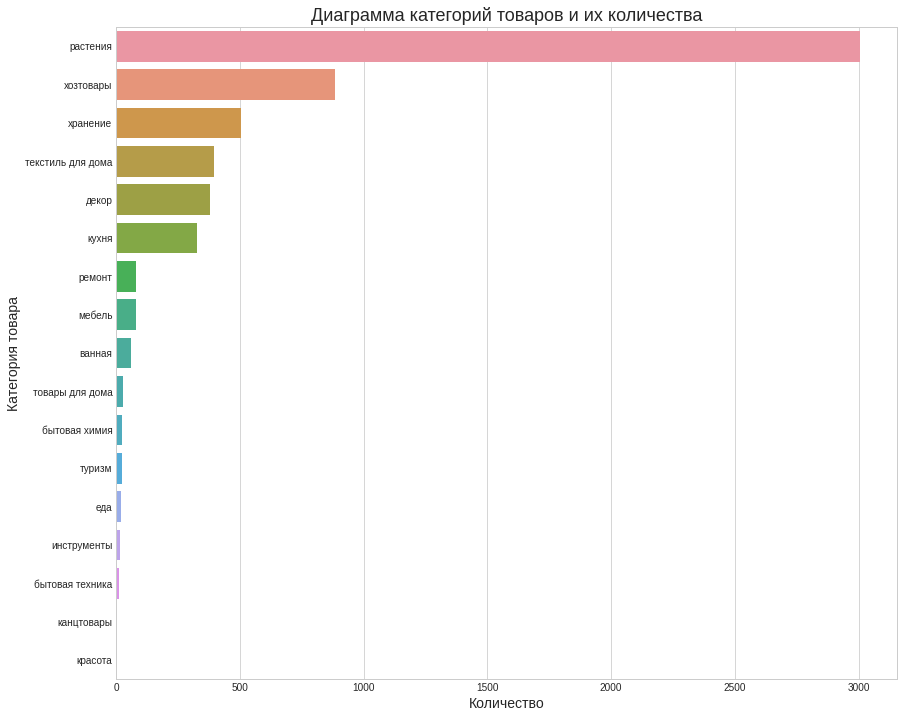

In [33]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(14, 12))
    sns.barplot(y=goods_type_count['category'], x=goods_type_count['count'])
    plt.title('Диаграмма категорий товаров и их количества', fontsize=18)
    plt.ylabel('Категория товара', fontsize=14)
    plt.xlabel('Количество', fontsize=14)
    plt.show()

<b>Взглянем на лидеров каждой из категорий</b>

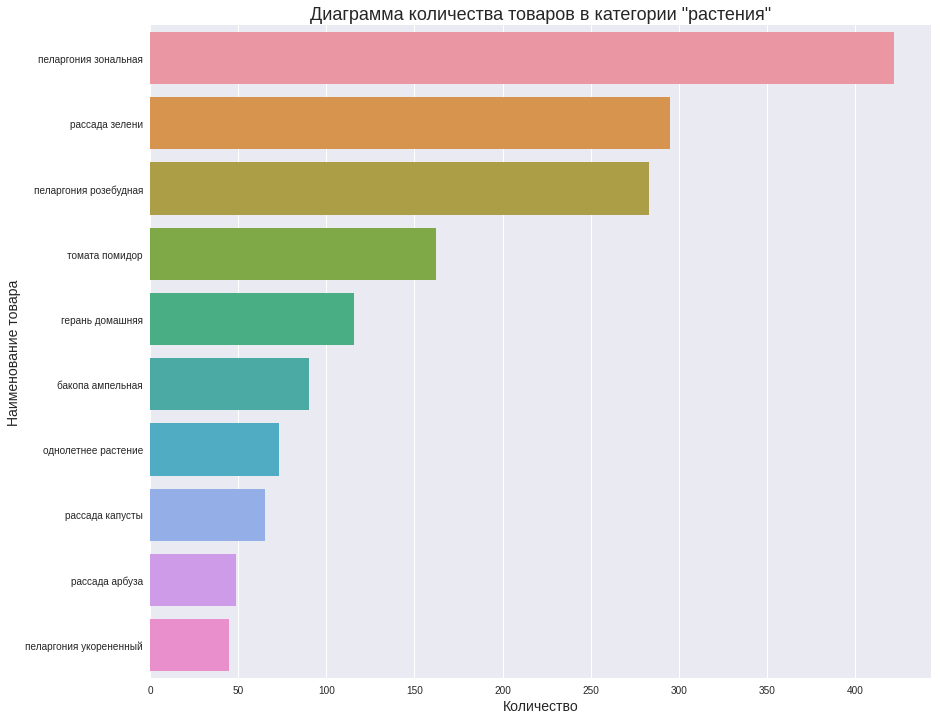

In [34]:
flowers = new_df.query('category == "растения"').groupby(['clear_frases']).agg({'product':'count'}).reset_index()
flowers = flowers.sort_values(by='product', ascending=False).head(10)
with plt.style.context('seaborn'):
    plt.figure(figsize=(14, 12))
    sns.barplot(y=flowers['clear_frases'], x=flowers['product'])
    plt.title('Диаграмма количества товаров в категории "растения"', fontsize=18)
    plt.ylabel('Наименование товара', fontsize=14)
    plt.xlabel('Количество', fontsize=14)
    plt.show()

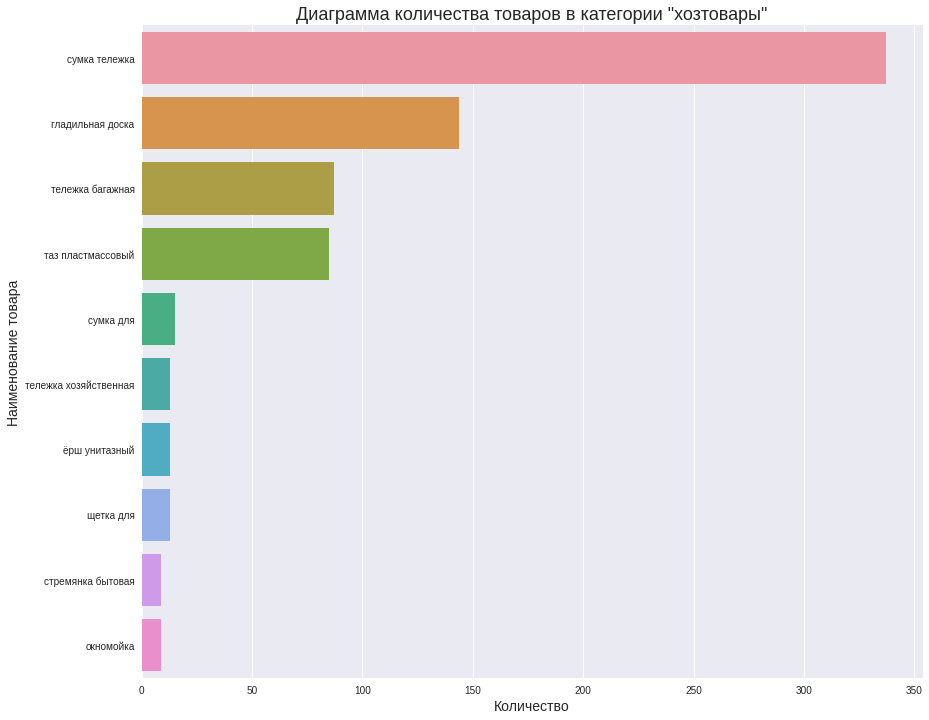

In [35]:
household_goods = new_df.query('category == "хозтовары"').groupby(['clear_frases']).agg({'product':'count'}).reset_index()
household_goods = household_goods.sort_values(by='product', ascending=False).head(10)
with plt.style.context('seaborn'):
    plt.figure(figsize=(14, 12))
    sns.barplot(y=household_goods['clear_frases'], x=household_goods['product'])
    plt.title('Диаграмма количества товаров в категории "хозтовары"', fontsize=18)
    plt.ylabel('Наименование товара', fontsize=14)
    plt.xlabel('Количество', fontsize=14)
    plt.show()

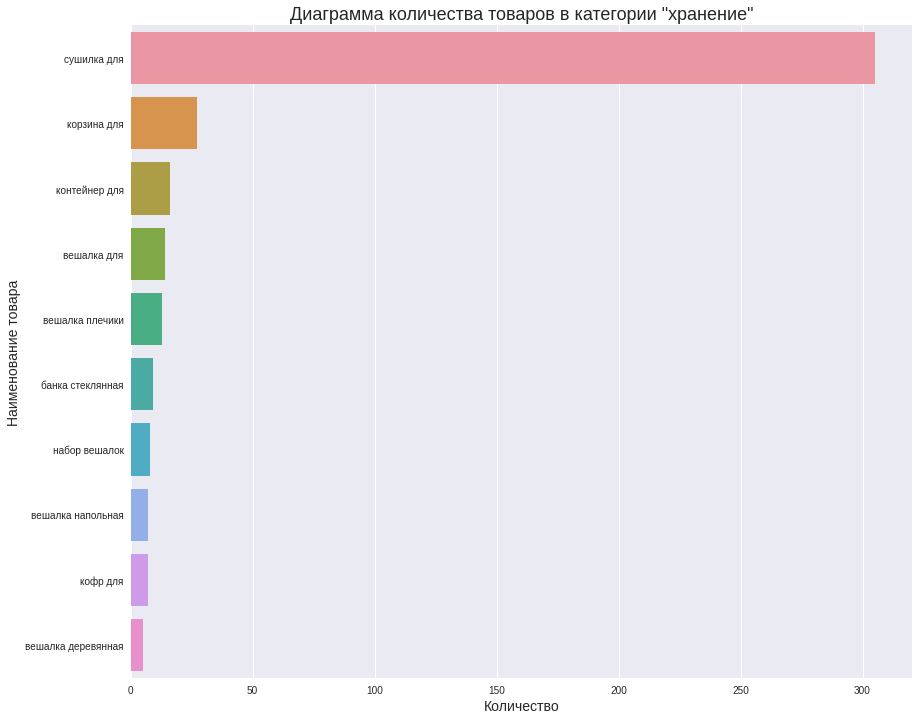

In [36]:
storage = new_df.query('category == "хранение"').groupby(['clear_frases']).agg({'product':'count'}).reset_index()
storage = storage.sort_values(by='product', ascending=False).head(10)
with plt.style.context('seaborn'):
    plt.figure(figsize=(14, 12))
    sns.barplot(y=storage['clear_frases'], x=storage['product'])
    plt.title('Диаграмма количества товаров в категории "хранение"', fontsize=18)
    plt.ylabel('Наименование товара', fontsize=14)
    plt.xlabel('Количество', fontsize=14)
    plt.show()

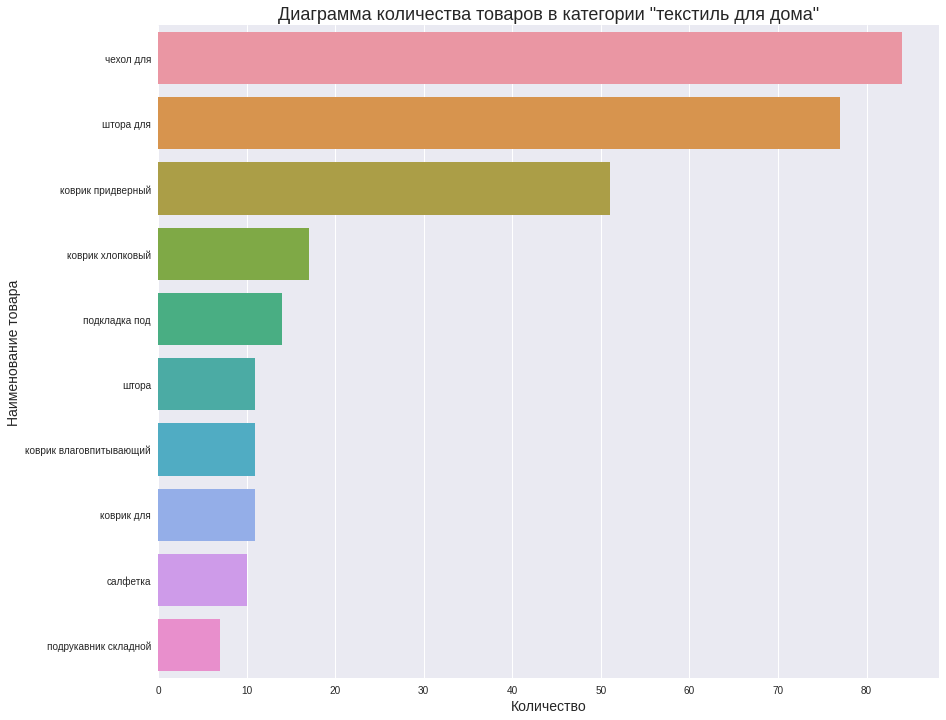

In [37]:
textiles = new_df.query('category == "текстиль для дома"').groupby(['clear_frases']).agg({'product':'count'}).reset_index()
textiles = textiles.sort_values(by='product', ascending=False).head(10)
with plt.style.context('seaborn'):
    plt.figure(figsize=(14, 12))
    sns.barplot(y=textiles['clear_frases'], x=textiles['product'])
    plt.title('Диаграмма количества товаров в категории "текстиль для дома"', fontsize=18)
    plt.ylabel('Наименование товара', fontsize=14)
    plt.xlabel('Количество', fontsize=14)
    plt.show()

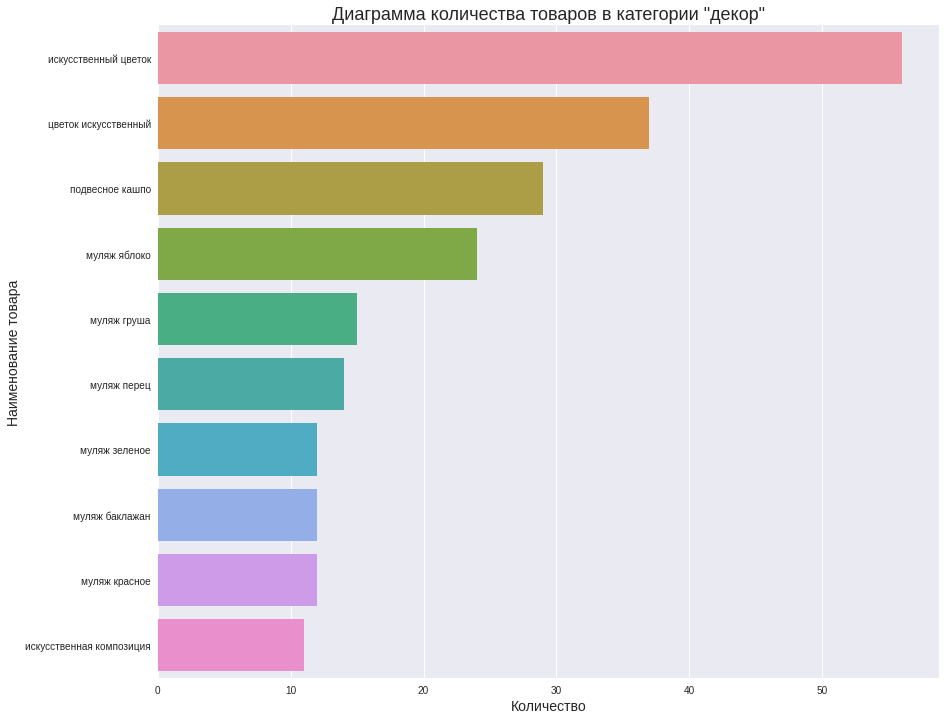

In [38]:
decor = new_df.query('category == "декор"').groupby(['clear_frases']).agg({'product':'count'}).reset_index()
decor = decor.sort_values(by='product', ascending=False).head(10)
with plt.style.context('seaborn'):
    plt.figure(figsize=(14, 12))
    sns.barplot(y=decor['clear_frases'], x=decor['product'])
    plt.title('Диаграмма количества товаров в категории "декор"', fontsize=18)
    plt.ylabel('Наименование товара', fontsize=14)
    plt.xlabel('Количество', fontsize=14)
    plt.show()

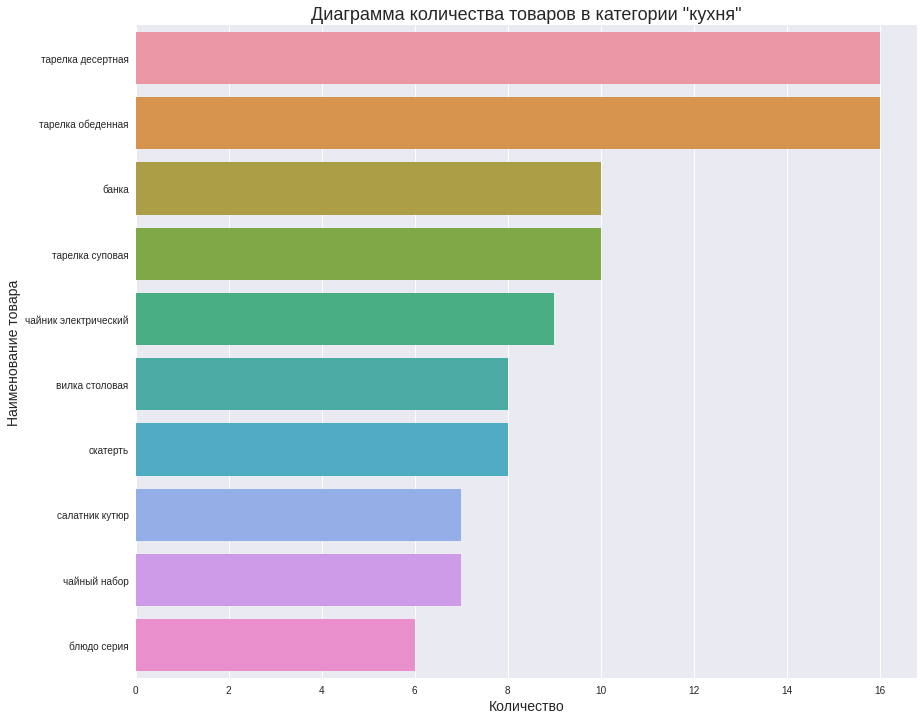

In [39]:
kitchen = new_df.query('category == "кухня"').groupby(['clear_frases']).agg({'product':'count'}).reset_index()
kitchen = kitchen.sort_values(by='product', ascending=False).head(10)
with plt.style.context('seaborn'):
    plt.figure(figsize=(14, 12))
    sns.barplot(y=kitchen['clear_frases'], x=kitchen['product'])
    plt.title('Диаграмма количества товаров в категории "кухня"', fontsize=18)
    plt.ylabel('Наименование товара', fontsize=14)
    plt.xlabel('Количество', fontsize=14)
    plt.show()

<b>Вывод:</b>
* Больше всего в нашем датасете категории "растения" - 3006, "хозтовары" - 886, "хранение" - 504
 * Самое частотные товары - пеларгония, сумка-тележка, чехлы
* Далее идут: "текстиль для дома" - 394, "декор" - 381, "кухня" - 328
    * Здесь лидеры - чехлы, искуственные цветки и тарелки
* Остальные категории в количество от 1 до 81

<b>Теперь взглянем на средний чек в категориях</b>

In [40]:
avg_pivot = new_df.pivot_table(index='category', values='total', aggfunc='mean').reset_index()
avg_pivot.columns = ['category', 'mean']
avg_pivot.sort_values(by='mean', ascending=False, inplace=True)

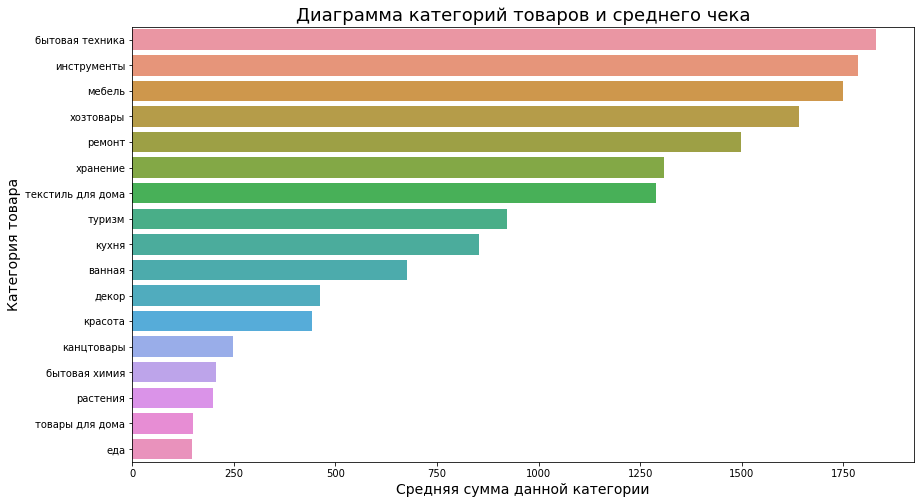

In [41]:
with plt.style.context('seaborn-pastel'):
    plt.figure(figsize=(14, 8))
    sns.barplot(y=avg_pivot['category'], x=avg_pivot['mean'])
    plt.title('Диаграмма категорий товаров и среднего чека', fontsize=18)
    plt.ylabel('Категория товара', fontsize=14)
    plt.xlabel('Средняя сумма данной категории', fontsize=14)
    plt.show()

<b>Вывод:</b>
* Если в диаграмме категорий растения, текстиль для дома, декор, кухня были в лидерах, то по средней сумме заказа в лидерах стали:
    * Бытовая техника - 1831, инструменты - 1785, ремонт - 1499, хозтовары - 1640, мебель - 1748 и хранение - 1308

Здесь всё логично - Бытовая техника всегда дорогая, как и инструменты. Ремонт тоже влетает в копеечку, а после мебель и средства для хранения и хозтовары

### Сегментация клиентов

<b>Применим кодирование категориального признака для будущей сегментации:</b>

In [42]:
cat_list = {'растения': 1, 'хозтовары' : 2, 'текстиль для дома' : 3, 'хранение' : 4, 'кухня' : 5,
       'декор' : 6, 'ванная' : 7, 'ремонт' : 8, 'мебель' : 9, 'бытовая химия' : 10, 'туризм' : 11,
       'инструменты' : 12, 'бытовая техника' : 13, 'канцтовары' : 14, 'товары для дома' : 15,
       'еда' : 16, 'красота' : 17}

In [43]:
def cat_encoder(category):
    return cat_list[category]

In [44]:
new_df['cat_encode'] = new_df['category'].apply(lambda x: cat_encoder(x))

<b>Взглянем на матрицу корреляции, тем самым исключим ненужные признаки</b>

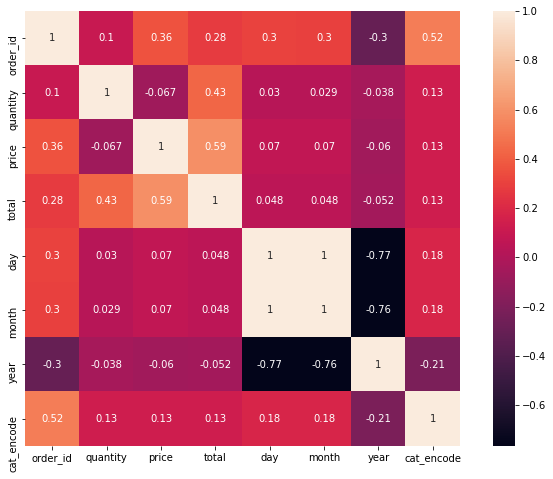

In [45]:
plt.figure(figsize=(12, 8))
sns.heatmap(new_df.corr(), annot=True, square=True)
plt.show()

In [46]:
scaler = StandardScaler()
x_sc = scaler.fit_transform(new_df.drop(columns = ['date', 'customer_id', 'product', 
                                                         'category', 'month', 'clear_frases']))

<b>Подберём оптимальное количество кластеров и лучшую метрику</b>

In [47]:
metric_list = []
cluster_list = []

In [48]:
for i in range(2, 10):
    km = KMeans(n_clusters=i, random_state=1)
    labels = km.fit_predict(x_sc)
    metric_list.append(silhouette_score(x_sc, labels))
    cluster_list.append(i)

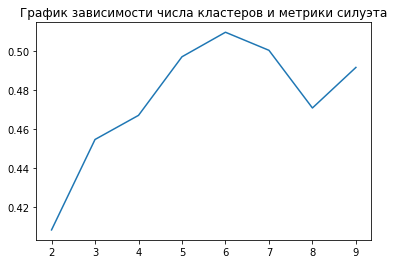

In [49]:
sns.lineplot(x=cluster_list, y = metric_list)
plt.title("График зависимости числа кластеров и метрики силуэта")
plt.show()

<b>Построим финальную модель кластеризации, с оптимальным числом кластеров</b>

In [50]:
km = KMeans(n_clusters=6, random_state=123)
labels = km.fit_predict(x_sc)
new_df['segment'] = labels
cluster_means = new_df[['quantity', 'price', 'total', 'segment']].groupby('segment').mean()

<b>Функция для отображения сегментов между двумя признаками</b>

In [51]:
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(16, 10))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

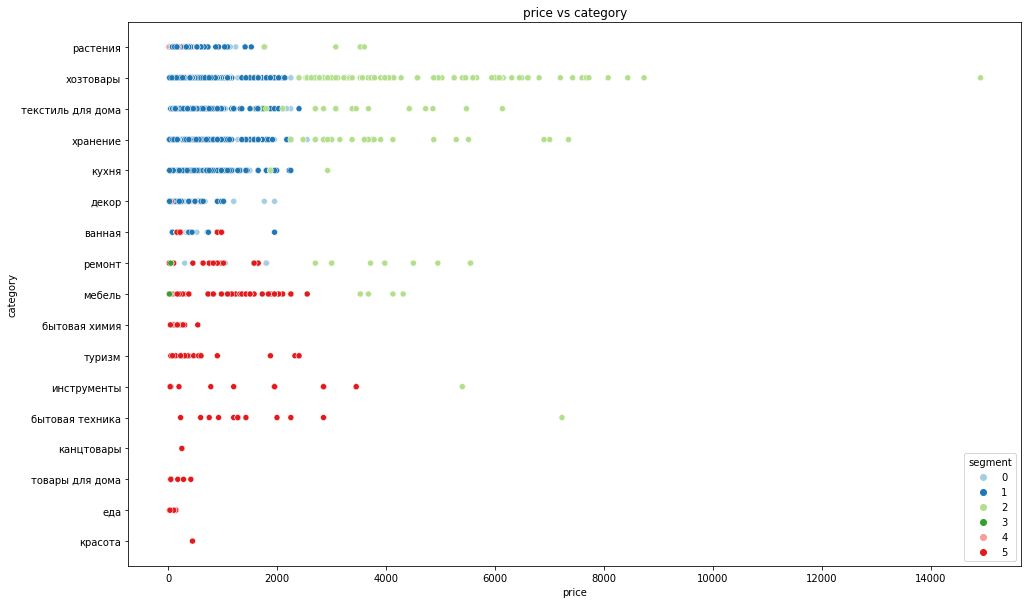

In [52]:
show_clusters_on_plot(new_df, 'price', 
                      'category', 
                      'segment')

<b>Взглянем на метрику силуэта</b>

In [53]:
silhouette_score(x_sc, labels)

0.5095163666816609

<b>Функция для отображения распределения категорий в сегменте</b>

In [54]:
def count_plot(segment_number):
    segment_count = new_df[new_df['segment'] == segment_number].groupby('category').agg({'quantity':'sum'}).reset_index()
    segment_count.columns = ['category', 'count']
    segment_count = segment_count.sort_values(by='count', ascending=False)
    with plt.style.context('seaborn-darkgrid'):
        plt.figure(figsize=(12, 10))
        sns.barplot(y=segment_count['category'], x=segment_count['count'])
        plt.title('Диаграмма категорий товаров и суммарного количества купленной продукции сегмента: {}'.format(segment_number), fontsize=18)
        plt.ylabel('Категория товара', fontsize=14)
        plt.xlabel('Суммарное количество купленных единиц продукции', fontsize=14)
        plt.show()

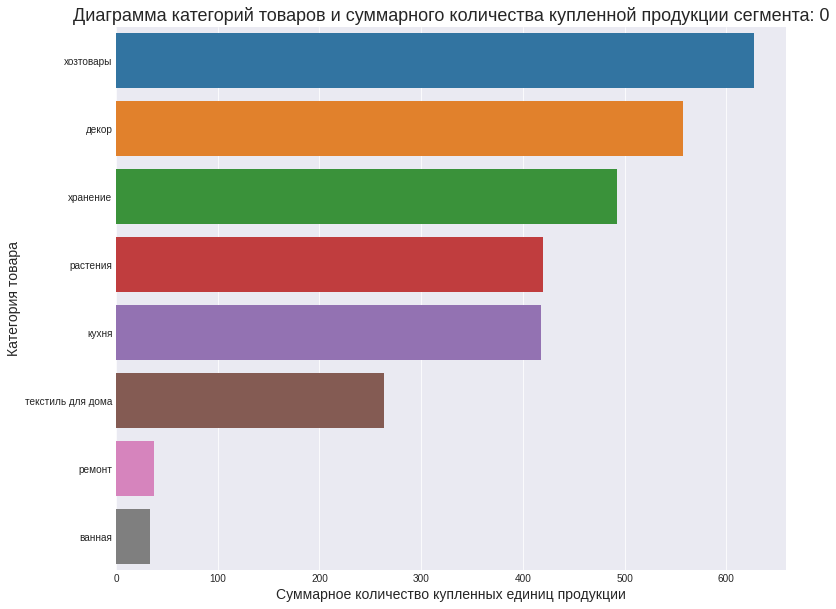

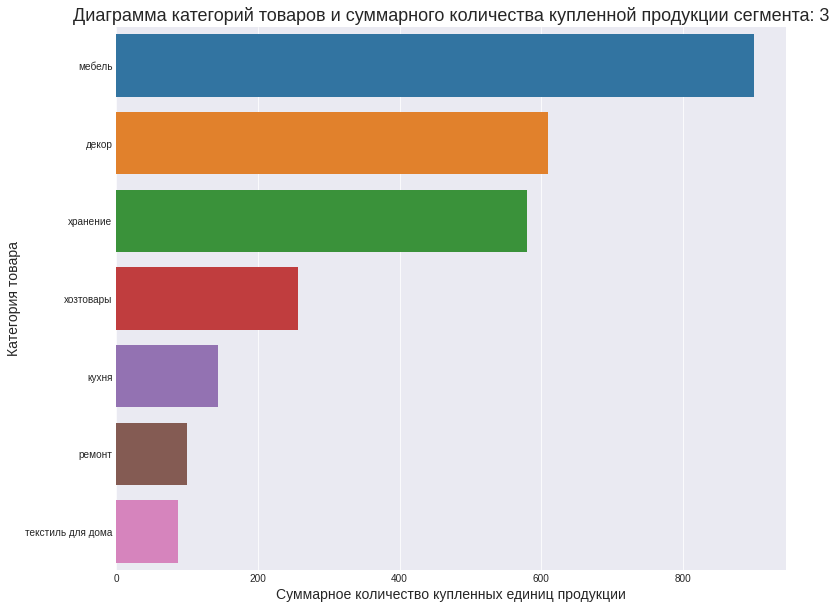

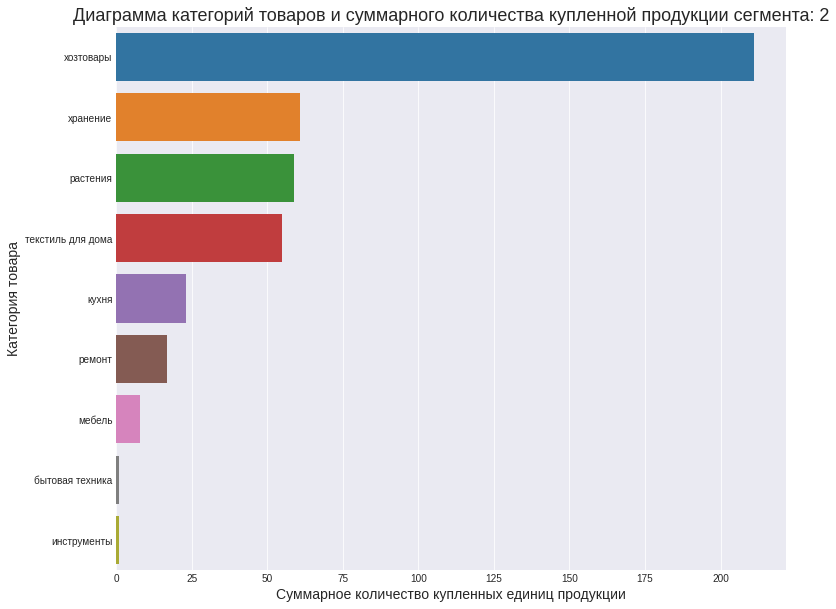

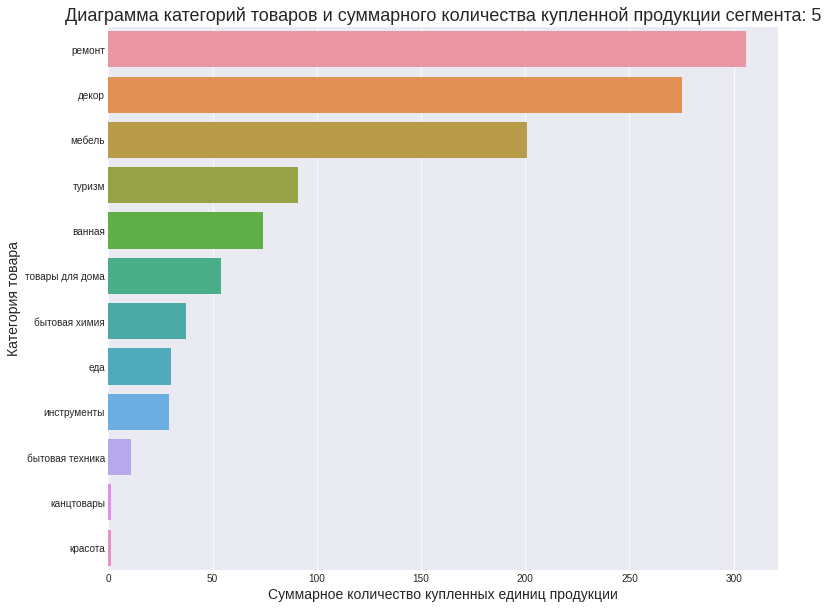

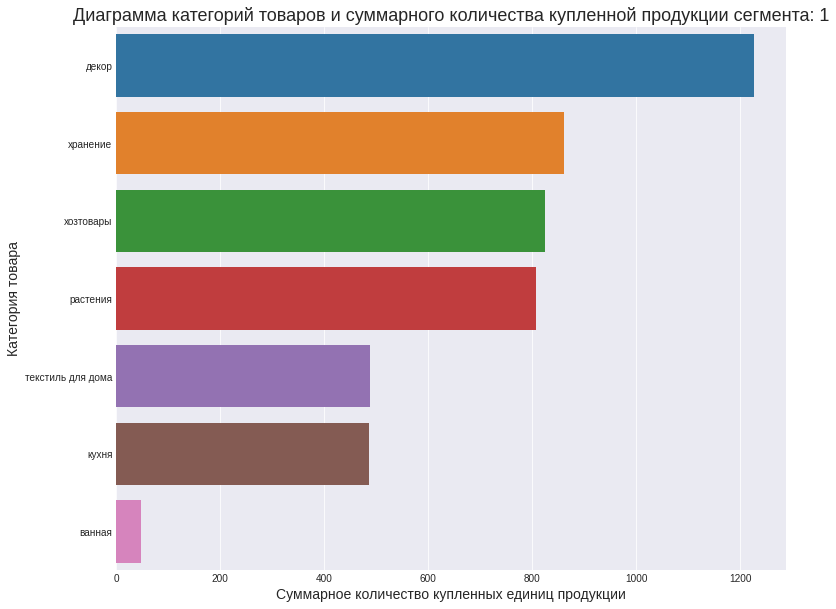

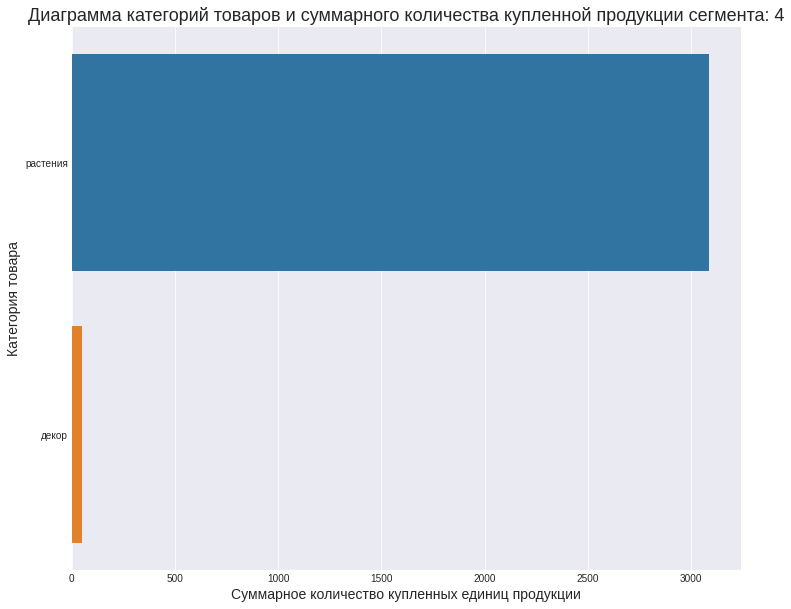

In [55]:
for i in new_df['segment'].unique():
    count_plot(i)

In [56]:
display(cluster_means)

,quantity,price,total
segment,,,
0,2.242520,452.603937,598.065354
1,2.630616,537.336661,710.731004
2,1.620818,3783.814126,4392.810409
3,133.900000,182.750000,12396.050000
4,1.400893,117.956696,159.984375
5,4.512195,688.788618,945.475610


<b>Выводы</b>

У нас 6 сегментов, в которых можно выделить следующие крупные категории:
* 0 сегмент - Хозтовары и во вторую очередь декор
* 1 сегмент - Декор и хранение
* 2 сегмент - Хозтовары. Хороший средний чек.
* 3 сегмент - Мебель и декор. Большой средний чек и количество купленных товаров
* 4 сегмент - Растения
* 5 сегмент - Ремонт и декор. Нормальный средний чек и количество позиций

## Проверка гипотез

<b>Статистическая значимость различий в среднем чеке между сегментированными группами</b>

<b>Гипотеза о равенстве средних чеков сегментов</b>

Нулевая гипотеза - средние чеки равны. Альтернативная гипотеза - средние чеки разные. Пороговый уровень - 0.05

In [57]:
alpha=0.05
seg_0 = new_df.query('segment == 0')['total']
seg_1 = new_df.query('segment == 1')['total']
seg_2 = new_df.query('segment == 2')['total']
seg_3 = new_df.query('segment == 3')['total']
seg_4 = new_df.query('segment == 4')['total']
seg_5 = new_df.query('segment == 5')['total']
print(len(seg_0), len(seg_1), len(seg_2), len(seg_3), len(seg_4), len(seg_5))

1270 1803 269 20 2240 246


<b>Посмотрим на распределения</b>

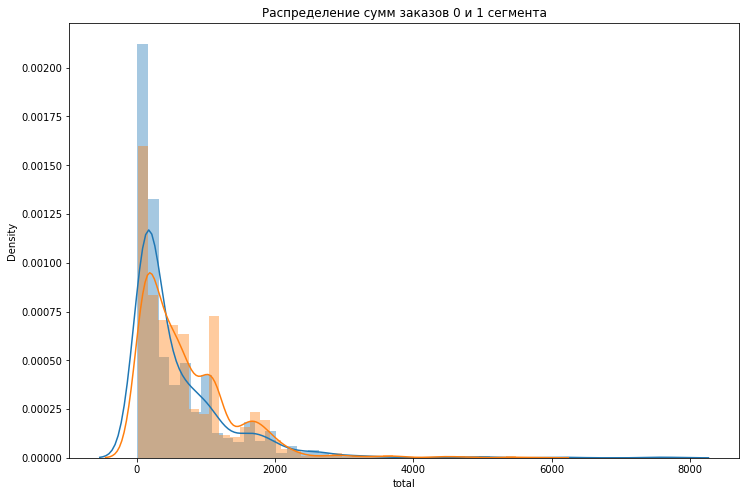

In [58]:
plt.figure(figsize=(12, 8))
sns.distplot(seg_0)
sns.distplot(seg_1)
plt.title("Распределение сумм заказов 0 и 1 сегмента")
plt.show()

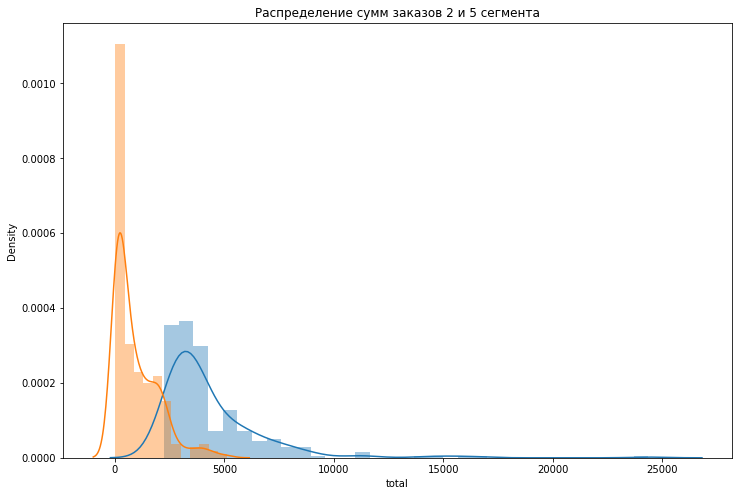

In [59]:
plt.figure(figsize=(12, 8))
sns.distplot(seg_2)
sns.distplot(seg_5)
plt.title("Распределение сумм заказов 2 и 5 сегмента")
plt.show()

<b>Распределения не являются нормальными(отсуствует выраженная Гауссиана), поэтому мы применим непараметрический тест Манна-Уитни</b>

In [60]:
stat, p = mannwhitneyu(seg_0, seg_1)
print('Статистика={}, p-значение={}'.format(stat, p))
if (p > alpha):
    print('Средний чек 0 и 1 сегмента одинаковый. H0 гипотеза не отвергнута')
else:
    print('Средний чек 0 и 1 сегмента разный. Принимаем гипотезу H1')

Статистика=962346.5, p-значение=4.747714612747332e-14
Средний чек 0 и 1 сегмента разный. Принимаем гипотезу H1


In [61]:
stat, p = mannwhitneyu(seg_2, seg_5)
print('Статистика={}, p-значение={}'.format(stat, p))
if (p > alpha):
    print('Средний чек 2 и 5 сегмента одинаковый. H0 гипотеза не отвергнута')
else:
    print('Средний чек 2 и 5 сегмента разный. Принимаем гипотезу H1')

Статистика=64295.0, p-значение=1.9383511474736703e-76
Средний чек 2 и 5 сегмента разный. Принимаем гипотезу H1


In [62]:
stat, p = mannwhitneyu(seg_0, seg_4)
print('Статистика={}, p-значение={}'.format(stat, p))
if (p > alpha):
    print('Средний чек 0 и 4 сегмента одинаковый. H0 гипотеза не отвергнута')
else:
    print('Средний чек 0 и 4 сегмента разный. Принимаем гипотезу H1')

Статистика=2159729.0, p-значение=3.038794981555214e-144
Средний чек 0 и 4 сегмента разный. Принимаем гипотезу H1


In [63]:
stat, p = mannwhitneyu(seg_1, seg_4)
print('Статистика={}, p-значение={}'.format(stat, p))
if (p > alpha):
    print('Средний чек 1 и 4 сегмента одинаковый. H0 гипотеза не отвергнута')
else:
    print('Средний чек 1 и 4 сегмента разный. Принимаем гипотезу H1')

Статистика=3336013.5, p-значение=3.602384014585303e-279
Средний чек 1 и 4 сегмента разный. Принимаем гипотезу H1


In [64]:
stat, p = mannwhitneyu(seg_2, seg_3)
print('Статистика={}, p-значение={}'.format(stat, p))
if (p > alpha):
    print('Средний чек 2 и 3 сегмента одинаковый. H0 гипотеза не отвергнута')
else:
    print('Средний чек 2 и 3 сегмента разный. Принимаем гипотезу H1')

Статистика=1786.0, p-значение=0.012184023367126994
Средний чек 2 и 3 сегмента разный. Принимаем гипотезу H1


In [65]:
stat, p = mannwhitneyu(seg_2, seg_5)
print('Статистика={}, p-значение={}'.format(stat, p))
if (p > alpha):
    print('Средний чек 2 и 5 сегмента одинаковый. H0 гипотеза не отвергнута')
else:
    print('Средний чек 2 и 5 сегмента разный. Принимаем гипотезу H1')

Статистика=64295.0, p-значение=1.9383511474736703e-76
Средний чек 2 и 5 сегмента разный. Принимаем гипотезу H1


<b>Выводы по гипотезам:</b>
* Были выбраны 6 сегментов попарно,
* Все распределения сегментов не являются нормальными и имеют положительный хвост, соответственно к исследованию применим непараметрический тест Манна-Уитни-Уилкоксона
* Тесты показали различие среднего чека в сегментах, что говорит нам - люди тратят в каждом сегменте разные суммы денег.

## Общий вывод

<b>Итоги</b>
* Мне достался датасет с некоторыми проблемами, требующими доработок. Кратко приведу ряд моментов, процесса его изучения
* Выявил следующие аномалии, которые требуют уточнения у отдела:
    * id заказа <b>71743</b> и id покупателя <b>312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6</b> решил отправить в отдел продаж(покупка одного дня, может быть тестовой), а из выборки удалил. В противном случае появляется сегмент дорогих покупок</b>
    * id заказа <b>14833</b> и id покупателя <b>1d6c8c1f-a799-4418-9af2-1ded47d7a85c</b> также направляю в отдел продаж - 888 позиций в разное время и дни, кабачки, огурцы, патиссоны и цветы
* Для более качественной кластеризации в будущем нужно будет больше данных для модели, а также проработать момент возможности добавления дополнительной информации о покупателях
* К концу года (сентябрь-октябрь 2018/19) наблюдается спрос на хозтовары, мебель и кухонные принадлежности. Для подтверждения тренда понадобится больше данных, но стоит принять во внимание
* Была проведена категоризация продуктов и выделено 17 категорий в которых:
    * Большое количество покупок растений мелкими суммами
    * По среднему чеку лидируют бытовая техника, инструменты, мебель и хозтовары - от 1600 до 1780
    * В каждой категории свои востребованные товары: тарелки в категории кухня, пеларгония в растениях, чехлы в текстиле, сумки-тележки в хозтоварах, сушилки для белья в хранении
* Далее, с помозью DS была построена модель, которая сегментировала покупки на 6 сегментов:
 - 0 сегмент - Хозтовары и декор
 - 1 сегмент - Декор и хранение
 - 2 сегмент - Хозтовары. Хороший средний чек.
 - 3 сегмент - Мебель и декор. Большой средний чек и количество купленных товаров
 - 4 сегмент - Растения
 - 5 сегмент - Ремонт и декор. Нормальный средний чек и количество позиций
* Метрика силуэта в ML модели показала средний результат, который нужно будет улучшать в дальнейшем, добавляя дополнительные признаки и количество данных

Задачу сегментирования считаю выполненной успешно. Статистические гипотезы подтвердили, что в большинстве сегментов средний чек разный, а это значит люди тратят разные суммы на покупки. Для каждого сегмента можно сформировать определённые предложения. Дополнительно рекомендую запустить АБ тестирование эффективности сегментирования